In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/Capstone/dataset.zip' -d '/content/drive/MyDrive/Capstone/Dataset'

Archive:  /content/drive/MyDrive/Capstone/dataset.zip
  inflating: /content/drive/MyDrive/Capstone/Dataset/classname.txt  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train.csv  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.1.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.10.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.100.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.101.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.102.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.103.jpg  
  inflating: /content/drive/MyDrive/Caps

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

In [3]:
TRAIN_DIR = "/content/drive/MyDrive/Capstone/Dataset/train"
VALIDATION_DIR = "/content/drive/MyDrive/Capstone/Dataset/val"

BATCH_SIZE = 32
IMAGE_SIZE =(224,224)
EPOCHS = 100

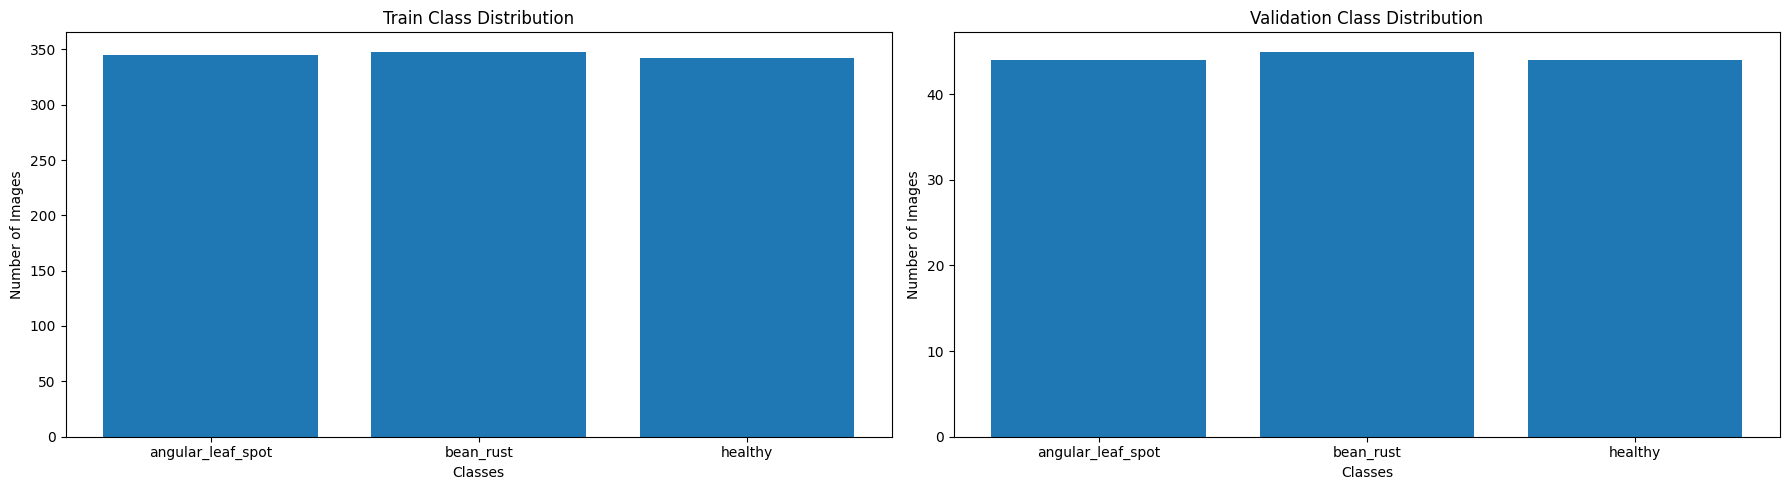

In [ ]:
import os
import matplotlib.pyplot as plt

# Paths to train, validation, and test directories
train_path = TRAIN_DIR
validation_path = VALIDATION_DIR

# Function to count the number of images in each class folder
def count_images_in_folders(path):
    class_counts = {}
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_folder] = num_images
    return class_counts

# Get class distributions for train, validation, and test sets
train_counts = count_images_in_folders(train_path)
validation_counts = count_images_in_folders(validation_path)

# Plotting the class distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Plot train class distribution
ax[0].bar(train_counts.keys(), train_counts.values())
ax[0].set_title('Train Class Distribution')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of Images')

# Plot validation class distribution
ax[1].bar(validation_counts.keys(), validation_counts.values())
ax[1].set_title('Validation Class Distribution')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    color_mode = "rgb"
)

validation_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    color_mode = "rgb",
    validation_split=0.1,
    subset="both",
    seed=0
)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Using 120 files for training.
Using 13 files for validation.


In [5]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

In [7]:
train_dataset = train_dataset.map(lambda x, y: (augmentation_layers(x, training=True), y))

In [8]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512,activation= "relu"),
    tf.keras.layers.Dense(units=512,activation= "relu"),
    tf.keras.layers.Dense(units=3,activation= "sigmoid"),
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics= ['accuracy', keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall"), keras.metrics.F1Score(average='macro', threshold=0.5, name="f1_score")]
)

In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,900,995 (94.99 MB)

 Trainable params: 1,313,283 (5.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
earlyStopping = tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10,
                                         verbose=1,  restore_best_weights=True)

In [12]:
model_history = model.fit(
	train_dataset,
	epochs=EPOCHS,
	validation_data=validation_dataset,
	callbacks = [earlyStopping]
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 257s 7s/step - accuracy: 0.3445 - f1_score: 0.3271 - loss: 1.3556 - precision: 0.3481 - recall: 0.3365 - val_accuracy: 0.3250 - val_f1_score: 0.1635 - val_loss: 1.1461 - val_precision: 0.3250 - val_recall: 0.3250
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - accuracy: 0.3330 - f1_score: 0.2962 - loss: 1.1394 - precision: 0.3459 - recall: 0.3324 - val_accuracy: 0.3917 - val_f1_score: 0.2592 - val_loss: 1.1038 - val_precision: 0.4059 - val_recall: 0.3417
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.3507 - f1_score: 0.1832 - loss: 1.1086 - precision: 0.3881 - recall: 0.1723 - val_accuracy: 0.3917 - val_f1_score: 0.2848 - val_loss: 1.0838 - val_precision: 0.3932 - val_recall: 0.3833
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.3599 - f1_score: 0.2824 - loss: 1.0948 - precision: 0.3547 - recall: 0.3373 - val_accuracy: 0.4417 - val_f1_score: 0.5456 - val_loss: 1.0709 - val_precision: 0.4213 - val_r


Val Accuracy: 0.6333333253860474
Val Precision: 0.4836956560611725
Val Recall: 0.7416666746139526
Val F1 Score: 0.5780089497566223


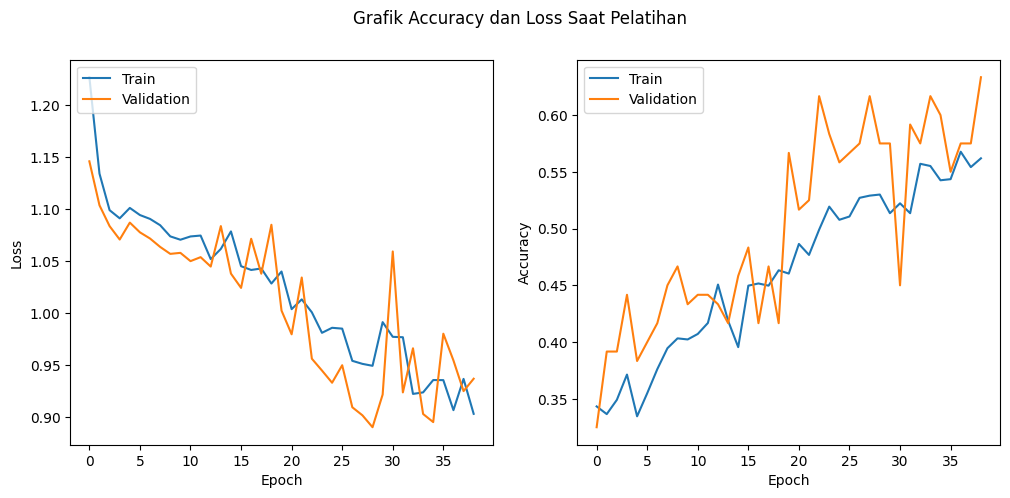

In [13]:
print("")
print(f"Val Accuracy: {(model_history.history['val_accuracy'])[-1]}")
print(f"Val Precision: {(model_history.history['val_precision'])[-1]}")
print(f"Val Recall: {(model_history.history['val_recall'])[-1]}")
print(f"Val F1 Score: {(model_history.history['val_f1_score'])[-1]}")

plt.figure(figsize=(12, 5))
plt.suptitle('Grafik Accuracy dan Loss Saat Pelatihan')

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
scores = model.evaluate(test_dataset)
print(f"Accuracy: {scores[1]}")
print(f"Precision: {scores[2]}")
print(f"Recall: {scores[3]}")
print(f"F1 Score: {scores[4]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3846 - f1_score: 0.6448 - loss: 1.0089 - precision: 0.5263 - recall: 0.7692
Accuracy: 0.38461539149284363
Precision: 0.5263158082962036
Recall: 0.7692307829856873
F1 Score: 0.6447811126708984


In [15]:
EXPORT_DIR = "/content/drive/MyDrive/Capstone/Models/20_Nov"
tf.saved_model.save(model, EXPORT_DIR)